<a href="https://colab.research.google.com/github/ylu149/Machine-Learning-Temperature-Prediction/blob/main/MLPNeuralNetwork_Weather_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data was downlaoded from: https://nsrdb.nrel.gov/data-viewer?fbclid=IwAR1fS7e06UkcSS8xOlFZksjbAemMYXQLMdbBYBWNv2b2y3v9MToz9hmLkHM.

Everything was saved to ML_30_data.zip. Please upload all excel files in that folder to run code.

In [ ]:
#Loading in all excel files
from google.colab import files
uploaded = files.upload()


Saving 1245245_40.73_-73.98_2017.csv to 1245245_40.73_-73.98_2017.csv
Saving 1245245_40.73_-73.98_2018.csv to 1245245_40.73_-73.98_2018.csv
Saving 1245245_40.73_-73.98_2019.csv to 1245245_40.73_-73.98_2019.csv
Saving 1245245_40.73_-73.98_2020.csv to 1245245_40.73_-73.98_2020.csv
Saving 1245245_40.73_-73.98_2021.csv to 1245245_40.73_-73.98_2021.csv
Saving 1245245_40.73_-73.98_2022.csv to 1245245_40.73_-73.98_2022.csv
Saving 1245245_40.73_-73.98_2003.csv to 1245245_40.73_-73.98_2003.csv
Saving 1245245_40.73_-73.98_2004.csv to 1245245_40.73_-73.98_2004.csv
Saving 1245245_40.73_-73.98_2005.csv to 1245245_40.73_-73.98_2005.csv
Saving 1245245_40.73_-73.98_2006.csv to 1245245_40.73_-73.98_2006.csv
Saving 1245245_40.73_-73.98_2007.csv to 1245245_40.73_-73.98_2007.csv
Saving 1245245_40.73_-73.98_2008.csv to 1245245_40.73_-73.98_2008.csv
Saving 1245245_40.73_-73.98_2009.csv to 1245245_40.73_-73.98_2009.csv
Saving 1245245_40.73_-73.98_2010.csv to 1245245_40.73_-73.98_2010.csv
Saving 1245245_40.73

# Machine Learning Regression Analaysis

In [ ]:
#loading all excel data to a list of pandas df
from numpy import iinfo
import io
import pandas as pd

yearRange = range(2000, 2023)
weatherDF = {}
numberHeaderLines = 2
csvStr = "1245245_40.73_-73.98_"

for year in yearRange:
  fileStr = csvStr + str(year) + ".csv"
  weatherDF[year] = pd.read_csv(io.BytesIO(uploaded[fileStr]), skiprows = numberHeaderLines)

#Adding a Timestamp and TimeSinceEpoch and deleting original time format
for year, df in weatherDF.items():
    df.insert(0, "Timestamp", pd.to_datetime(df[["Year", "Month", "Day", "Hour", "Minute"]]), True)
    df["TimeSinceEpoch"] = (df["Timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    df.drop(["Year", "Month", "Day", "Hour", "Minute"], axis=1, inplace = True)
    ColOrder = ["Timestamp", "Temperature", "TimeSinceEpoch", "Relative Humidity", "Pressure", "Dew Point", "Wind Speed"]
    weatherDF[year] = df[ColOrder]

#Combining all data frames into 1 and get sample data
weatherAll = pd.concat(weatherDF.values(), ignore_index=True)


#gets the max temp of each day and added a max temp column
grouped_by_date = weatherAll.groupby(weatherAll['Timestamp'].dt.date)
max_temperatures = grouped_by_date['Temperature'].transform('max')
weatherAll.insert(2, "Max Temperature", max_temperatures.values, True)

weatherAll.insert(8, "target temperature", weatherAll['Max Temperature'].shift(-48), True)
weatherAll = weatherAll[:-48]
weatherAll.head()

,Timestamp,Temperature,Max Temperature,TimeSinceEpoch,Relative Humidity,Pressure,Dew Point,Wind Speed,target temperature
0,2000-01-01 00:00:00,0.6,7.5,946684800,87.21,1018,-1.3,1.4,8.3
1,2000-01-01 00:30:00,0.5,7.5,946686600,87.84,1018,-1.3,1.4,8.3
2,2000-01-01 01:00:00,0.4,7.5,946688400,90.30,1019,-1.0,1.5,8.3
3,2000-01-01 01:30:00,0.3,7.5,946690200,90.96,1019,-1.0,1.6,8.3
4,2000-01-01 02:00:00,0.3,7.5,946692000,92.65,1019,-0.8,1.6,8.3


In [ ]:
#Checking for NaN Values in csv
for ii in weatherAll:
  check_nan = weatherAll[ii].isnull().values.any()
  print(ii, ": ", check_nan)

Timestamp :  False
Temperature :  False
Max Temperature :  False
TimeSinceEpoch :  False
Relative Humidity :  False
Pressure :  False
Dew Point :  False
Wind Speed :  False
target temperature :  False


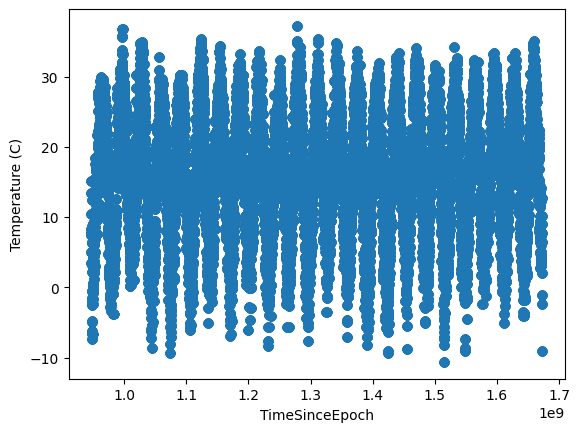

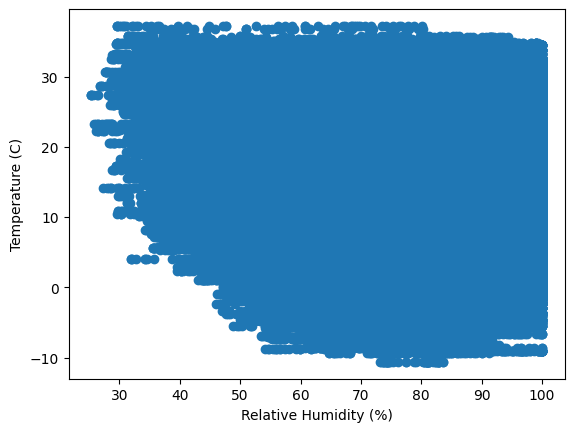

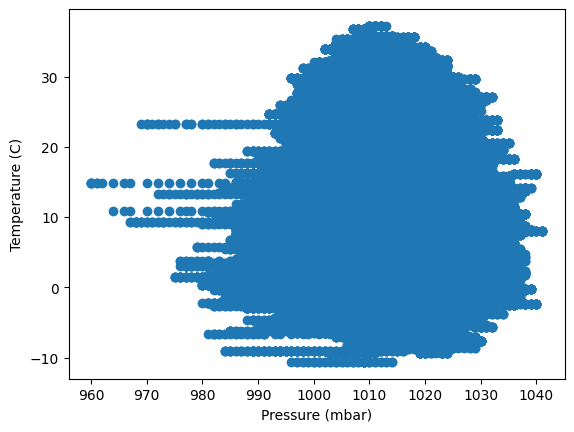

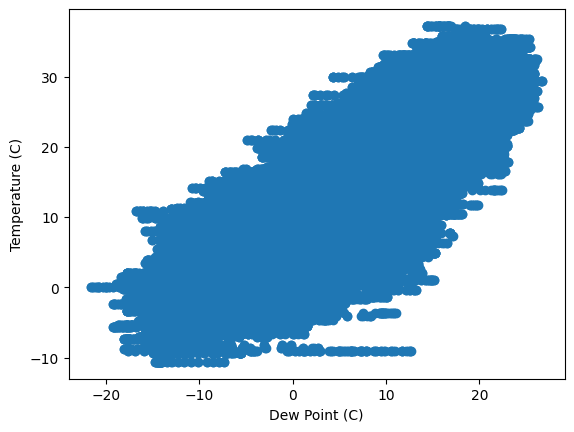

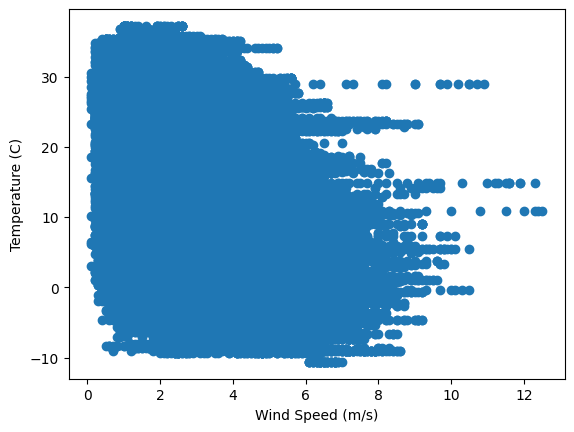

In [ ]:
#Getting a plot of all tempearture vs all the features
import matplotlib.pyplot as plt
xLabel = {
    2: "Max Temperature (C)",
    3: "TimeSinceEpoch",
    4: "Relative Humidity (%)",
    5: "Pressure (mbar)",
    6: "Dew Point (C)",
    7: "Wind Speed (m/s)"
  }

df = weatherAll

for ii in range(3, 8):
  plt.scatter(df.iloc[:, ii], df.iloc[:, 8])
  plt.xlabel(xLabel.get(ii))
  plt.ylabel("Temperature (C)")
  plt.show()


In [ ]:
#Getting all needed imports from sklearn
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
#preparing data for sklearn regression
rr = Ridge(alpha = 0.1)
predictors = weatherAll.columns[~weatherAll.columns.isin(["target temperature", "Temperature", "Pressure", "Timestamp"])]
target = ["target temperature"]

weatherAll[predictors]
predictors

Index(['Max Temperature', 'TimeSinceEpoch', 'Relative Humidity', 'Dew Point',
       'Wind Speed'],
      dtype='object')

In [ ]:
#Credits: https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn
#preparing test set and training set
x = weatherAll[predictors].values
y = weatherAll[target].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=40, shuffle=False)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print(X_train.shape)
print(X_test.shape)
print()
print(y_test.shape)
print(y_train.shape)


(282038, 5)
(120874, 5)

(120874,)
(282038,)


Lasso Regression
Mean Squared Error Training Data:  3.0934797084902925
R2 Score Training Data: 0.9022720989047475 

Mean Squared Error Test Data:  3.2189564545670475
R2 Score Training Data: 0.8889460950405116


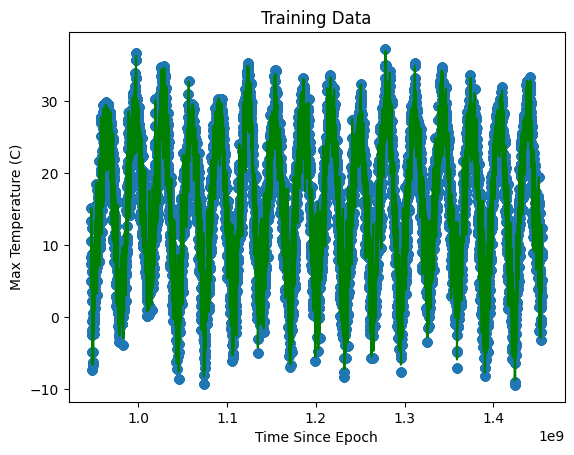

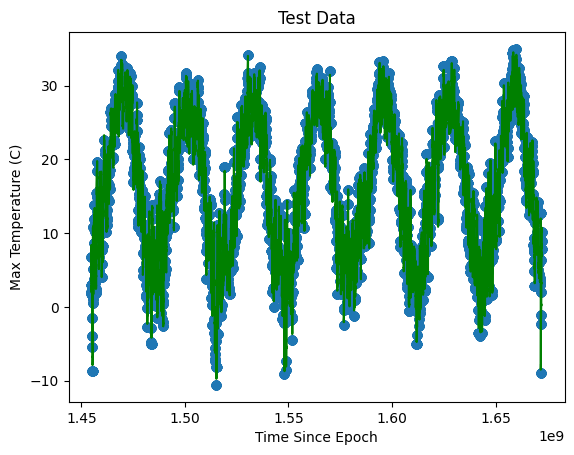

In [ ]:
#Lasso regression
print("Lasso Regression")
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train)
pred_train_lasso = model_lasso.predict(X_train)
print("Mean Squared Error Training Data: ",np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print("R2 Score Training Data:",r2_score(y_train, pred_train_lasso),"\n")

pred_test_lasso = model_lasso.predict(X_test)
print("Mean Squared Error Test Data: ",np.sqrt(mean_squared_error(y_test,pred_test_lasso)))
print("R2 Score Training Data:", r2_score(y_test, pred_test_lasso))

plt.title("Training Data")
plt.xlabel("Time Since Epoch")
plt.ylabel("Max Temperature (C)")
plt.plot(X_train[:, 1], pred_train_lasso, color='green')
plt.scatter(X_train[:, 1], y_train, color='C0')
plt.show()

plt.title("Test Data")
plt.xlabel("Time Since Epoch")
plt.ylabel("Max Temperature (C)")
plt.plot(X_test[:, 1], pred_test_lasso, color='green')
plt.scatter(X_test[:, 1], y_test, color='C0')
plt.show()

Ridge Regression
Mean Squared Error Training Data: 3.093467991942878
R2 Score Training Data: 0.9022728391917553

Mean Squared Error Test Data: 3.21853599406073
R2 Score Test Data 0.8889751048964653


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.3527e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


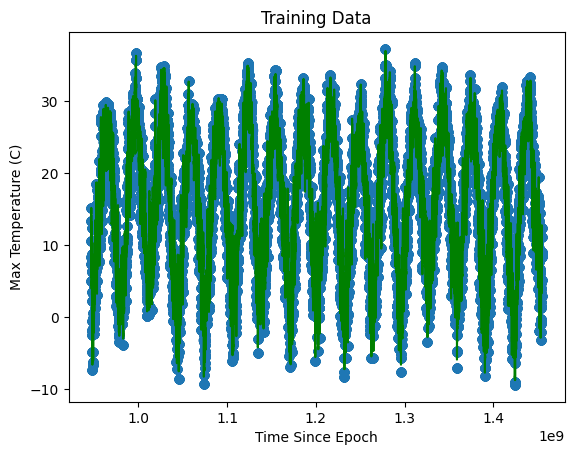

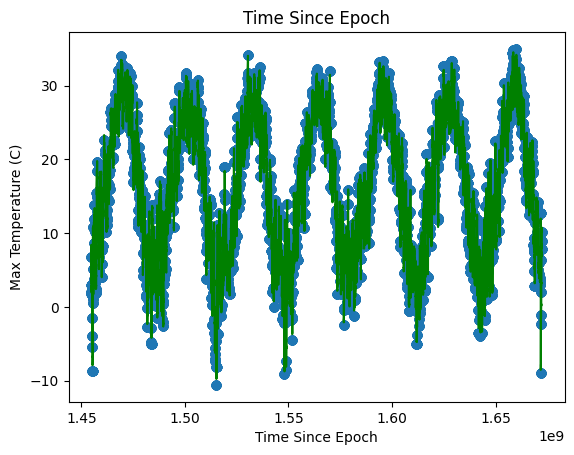

In [ ]:
#ridge
print("Ridge Regression")
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train)
pred_train_rr= rr.predict(X_train)
print("Mean Squared Error Training Data:", np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print("R2 Score Training Data:", r2_score(y_train, pred_train_rr))
print();
pred_test_rr= rr.predict(X_test)
print("Mean Squared Error Test Data:", np.sqrt(mean_squared_error(y_test,pred_test_rr)))
print("R2 Score Test Data", r2_score(y_test, pred_test_rr))

plt.title("Training Data")
plt.xlabel("Time Since Epoch")
plt.ylabel("Max Temperature (C)")
plt.plot(X_train[:, 1], pred_train_rr, color='green')
plt.scatter(X_train[:, 1], y_train, color='C0')
plt.show()

plt.title("Time Since Epoch")
plt.xlabel("Time Since Epoch")
plt.ylabel("Max Temperature (C)")
plt.plot(X_test[:, 1], pred_test_rr, color='green')
plt.scatter(X_test[:, 1], y_test, color='C0')
plt.show()

Linear Regression
Mean Squared Error Training Data: 3.093467991942878
R2 Score Training Data: 0.9022728391917553

Mean Squared Error Test Data: 3.218535993931462
R2 Score Test Data: 0.8889751049053836


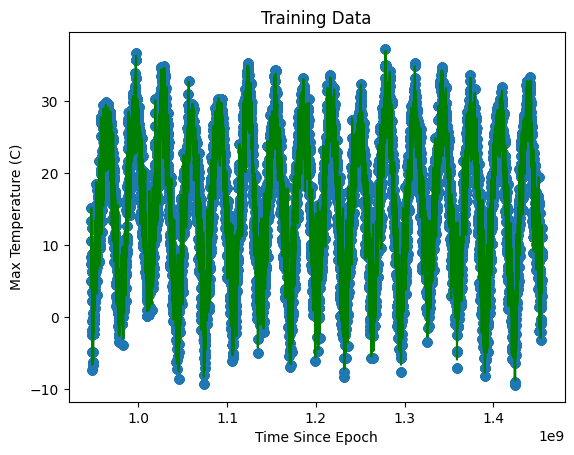

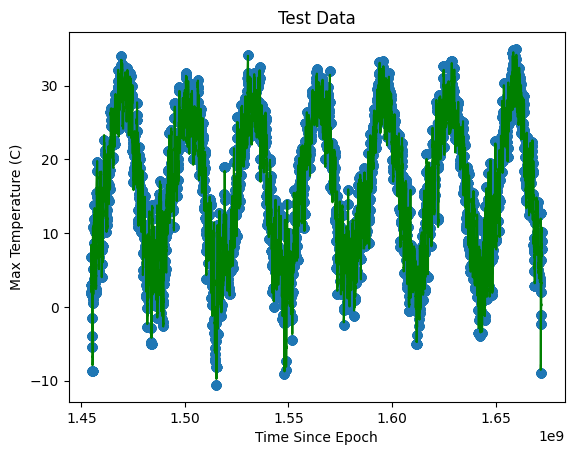

In [ ]:
#linear
print("Linear Regression")
lr = LinearRegression()
lr.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)

pred_train_lr= lr.predict(X_train)
print("Mean Squared Error Training Data:", np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print("R2 Score Training Data:", r2_score(y_train, pred_train_lr))
print()
pred_test_lr= lr.predict(X_test)
print("Mean Squared Error Test Data:", np.sqrt(mean_squared_error(y_test,pred_test_lr)))
print("R2 Score Test Data:", r2_score(y_test, pred_test_lr))

plt.title("Training Data")
plt.xlabel("Time Since Epoch")
plt.ylabel("Max Temperature (C)")
plt.plot(X_train[:, 1], pred_train_lr, color='green')
plt.scatter(X_train[:, 1], y_train, color='C0')
plt.show()

plt.title("Test Data")
plt.xlabel("Time Since Epoch")
plt.ylabel("Max Temperature (C)")
plt.plot(X_test[:, 1], pred_test_lr, color='green')
plt.scatter(X_test[:, 1], y_test, color='C0')
plt.show()

MLP Regression
Mean Squared Error Training Data: 2.9525606016771375
R2 Score Training Data: 0.9109730143543793

Mean Squared Error Test Data: 3.2129569674343417
R2 Score Test Data: 0.8893596735339853


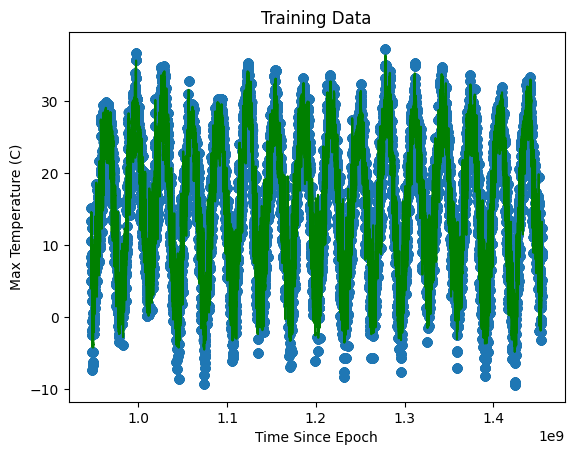

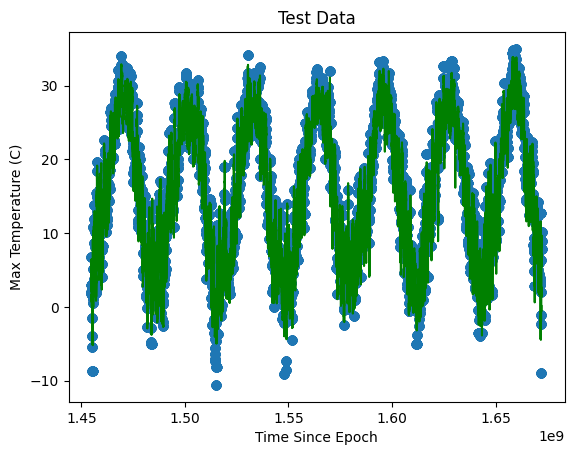

In [ ]:
#mlp
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

print("MLP Regression")
mlp = MLPRegressor(
    hidden_layer_sizes=(80, 40, 20),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size="auto",
    learning_rate='invscaling',
    learning_rate_init=0.0001,
    power_t=0.5,
    max_iter=500,
    shuffle=True,
    random_state=42,
    tol=1e-2,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=True,
    validation_fraction=0.1,
    beta_1=0.95,
    beta_2=0.999,
    epsilon=1e-8,
    n_iter_no_change=50
)

scaler_X = StandardScaler()
X_scaled_train = scaler_X.fit_transform(X_train)
X_scaled_test = scaler_X.fit_transform(X_test)


mlp.fit(X_scaled_train, y_train)
pred_train_mlp = mlp.predict(X_scaled_train)

print("Mean Squared Error Training Data:", np.sqrt(mean_squared_error(y_train,pred_train_mlp)))
print("R2 Score Training Data:", r2_score(y_train, pred_train_mlp))
print()

pred_test_mlp= mlp.predict(X_scaled_test)
print("Mean Squared Error Test Data:", np.sqrt(mean_squared_error(y_test,pred_test_mlp)))
print("R2 Score Test Data:", r2_score(y_test, pred_test_mlp))

plt.title("Training Data")
plt.xlabel("Time Since Epoch")
plt.ylabel("Max Temperature (C)")
plt.plot(X_train[:, 1], pred_train_mlp, color='green')
plt.scatter(X_train[:, 1], y_train, color='C0')
plt.show()

plt.title("Test Data")
plt.xlabel("Time Since Epoch")
plt.ylabel("Max Temperature (C)")
plt.plot(X_test[:, 1], pred_test_mlp, color='green')
plt.scatter(X_test[:, 1], y_test, color='C0')
plt.show()